# Fine-Tuning et Transfer Learning en NLP avec Keras 3 et KerasNLP
## Génération de Critiques de Films avec GPT-2 sur IMDB

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer le **fine-tuning** et le **transfer learning** pour la génération de texte en NLP avec **Keras 3** et **KerasNLP** :

1. **Comprendre le Transfer Learning** - Réutiliser des connaissances pré-apprises
2. **Utiliser KerasNLP** - API moderne et intégrée pour le NLP
3. **Charger GPT-2 avec KerasNLP** - Modèle pré-entraîné prêt à l'emploi
4. **Fine-tuning sur IMDB** - Adapter le modèle aux critiques de films
5. **Génération conditionnelle** - Créer des critiques cohérentes

Nous utiliserons le célèbre dataset **IMDB** (50,000 critiques de films) pour fine-tuner GPT-2 et générer des critiques authentiques.

## Pourquoi Keras 3 et KerasNLP ?

**Keras 3** (2023+) apporte :
- **Multi-backend** : TensorFlow, JAX, PyTorch
- **Performance optimisée** : Compilation XLA automatique
- **API moderne** : Plus simple et cohérente

**KerasNLP** offre :
- **Modèles pré-entraînés** : GPT-2, BERT, T5, etc.
- **Tokenizers intégrés** : Compatibles avec les modèles
- **Pipeline simplifié** : De la tokenization à la génération
- **Fine-tuning facile** : API haut niveau

## 📚 Concepts clés que nous allons explorer

- **Modèles pré-entraînés** : GPT-2 via KerasNLP
- **Feature Extraction** : Utiliser les représentations apprises (frozen)
- **Fine-Tuning** : Adapter les poids du modèle (unfrozen)
- **Freezing vs Unfreezing** : Stratégies de fine-tuning
- **Génération conditionnelle** : Contrôler la génération de texte

## 🎯 Architecture du notebook

```
Installation → KerasNLP GPT-2 → Exploration IMDB → Baseline (frozen) → Fine-tuning → Comparaison → Génération
```

## 1. Installation et Configuration

In [3]:
# Installation des dépendances (décommentez si nécessaire)
# !pip install -q tensorflow>=2.16.0
# !pip install -q keras>=3.0.0
# !pip install -q keras-nlp>=0.14.0
# !pip install -q datasets

print("✅ Installation terminée !")

✅ Installation terminée !


In [4]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML
import warnings
import textwrap
import os
warnings.filterwarnings('ignore')

# Configurer Keras pour utiliser TensorFlow backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

# TensorFlow et Keras 3
import tensorflow as tf
import keras
from keras import ops

# KerasNLP
import keras_nlp

# Datasets
from datasets import load_dataset

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU (entraînement sera lent)")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
keras.utils.set_random_seed(42)
np.random.seed(42)

print(f"\n📦 Versions des bibliothèques :")
print(f"  - TensorFlow : {tf.__version__}")
print(f"  - Keras      : {keras.__version__}")
print(f"  - KerasNLP   : {keras_nlp.__version__}")
print(f"  - Backend    : {keras.backend.backend()}")

print(f"\n🚀 Prêt pour le fine-tuning avec Keras 3 et KerasNLP !")

✅ GPU(s) détecté(s): 1 - Croissance mémoire activée

📦 Versions des bibliothèques :
  - TensorFlow : 2.19.1
  - Keras      : 3.11.3
  - KerasNLP   : 0.23.0
  - Backend    : tensorflow

🚀 Prêt pour le fine-tuning avec Keras 3 et KerasNLP !


## 2. Comprendre le Transfer Learning

### 2.1 Qu'est-ce que le Transfer Learning ?

Le transfer learning consiste à **transférer** les connaissances d'un modèle pré-entraîné vers une nouvelle tâche.

#### Analogie : Apprendre une nouvelle langue

Imaginez que vous parlez déjà français et anglais :
- **Pré-entraînement** : Vous avez appris le français (grammaire, vocabulaire, syntaxe)
- **Transfer Learning** : Apprendre l'espagnol est plus facile car vous connaissez déjà les concepts linguistiques
- **Fine-Tuning** : Adapter vos connaissances linguistiques à l'espagnol spécifiquement

### 2.2 Les deux approches principales

#### 🧊 Feature Extraction (Frozen)
```
Modèle pré-entraîné → [FREEZE] → Ajouter couches spécifiques → Entraîner seulement les nouvelles couches
```
- **Avantages** : Rapide, peu de données nécessaires, pas de catastrophic forgetting
- **Inconvénients** : Performances limitées si la tâche est très différente

#### 🔥 Fine-Tuning (Unfrozen)
```
Modèle pré-entraîné → [UNFREEZE] → Ajuster tous les poids → Learning rate faible
```
- **Avantages** : Meilleures performances, adaptation complète à la tâche
- **Inconvénients** : Plus lent, risque d'overfitting, nécessite plus de données

### 2.3 Visualisation du Transfer Learning

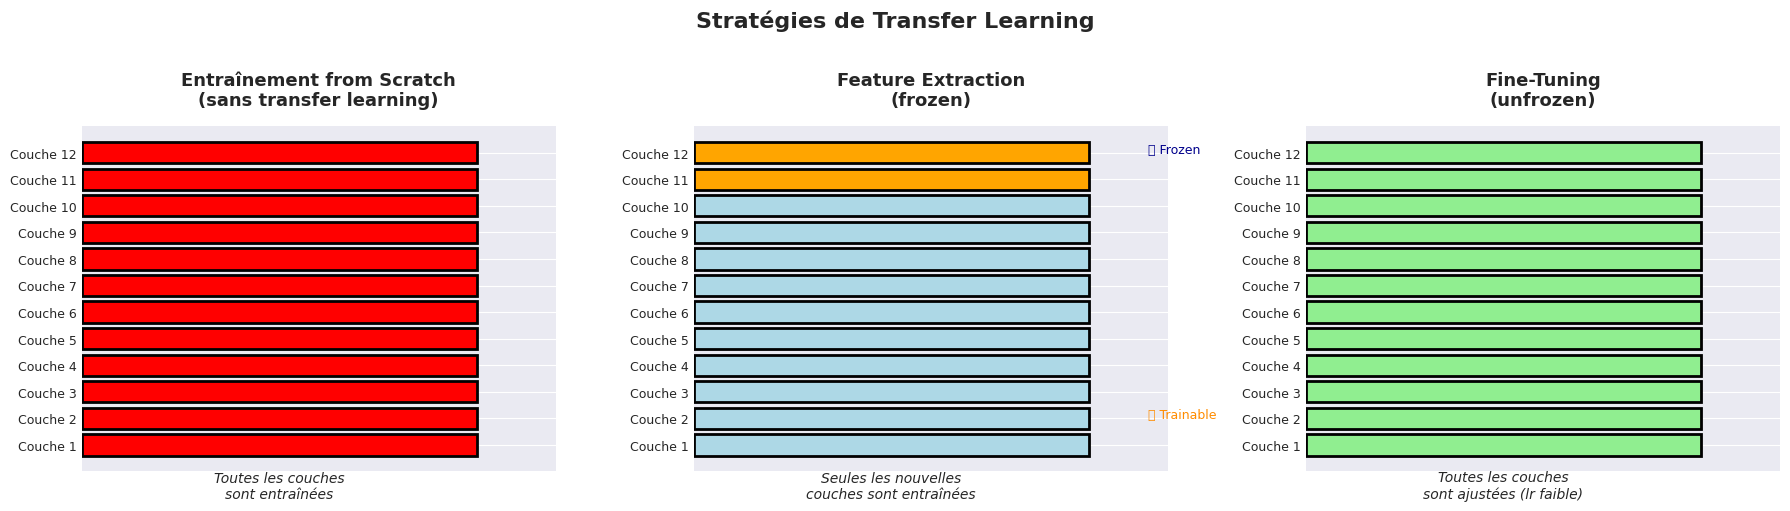


💡 Dans ce notebook, nous allons explorer les deux approches avec KerasNLP !


In [5]:
# Visualisation des stratégies de transfer learning
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

strategies = [
    ("Entraînement from Scratch\n(sans transfer learning)", 
     ['red']*12, "Toutes les couches\nsont entraînées"),
    ("Feature Extraction\n(frozen)", 
     ['lightblue']*10 + ['orange']*2, "Seules les nouvelles\ncouches sont entraînées"),
    ("Fine-Tuning\n(unfrozen)", 
     ['lightgreen']*12, "Toutes les couches\nsont ajustées (lr faible)")
]

for idx, (title, colors, desc) in enumerate(strategies):
    ax = axes[idx]
    
    # Dessiner les couches
    for i, color in enumerate(colors):
        ax.barh(i, 1, color=color, edgecolor='black', linewidth=2)
    
    ax.set_ylim(-1, 12)
    ax.set_xlim(0, 1.2)
    ax.set_yticks(range(12))
    ax.set_yticklabels([f'Couche {i+1}' for i in range(12)], fontsize=9)
    ax.set_xticks([])
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    ax.text(0.5, -2, desc, ha='center', fontsize=10, style='italic')
    
    # Légende
    if idx == 1:
        ax.text(1.15, 11, '🔒 Frozen', fontsize=9, color='darkblue')
        ax.text(1.15, 1, '🔓 Trainable', fontsize=9, color='darkorange')

plt.suptitle('Stratégies de Transfer Learning', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Dans ce notebook, nous allons explorer les deux approches avec KerasNLP !")

## 3. Chargement du Modèle Pré-entraîné avec KerasNLP : GPT-2

### 3.1 Pourquoi GPT-2 avec KerasNLP ?

**GPT-2** (Generative Pre-trained Transformer 2) :
- **124M paramètres** (version gpt2_base_en)
- Pré-entraîné sur **40GB de texte** (WebText)
- Architecture **decoder-only** optimisée pour la génération
- Génération **auto-régressive** de haute qualité

**KerasNLP simplifie** :
- Chargement en une ligne : `GPT2CausalLM.from_preset()`
- Tokenizer intégré et compatible
- Génération simplifiée : méthode `generate()`
- Fine-tuning natif avec Keras

### 3.2 Architecture GPT-2

```
Input Text → Tokenization → [Transformer Blocks × 12] → Language Modeling Head → Next Token
```

Chaque bloc Transformer contient :
- Multi-Head Self-Attention (12 heads)
- Feed-Forward Network
- Layer Normalization
- Residual Connections

In [6]:
print("📥 Chargement du modèle GPT-2 avec KerasNLP...")
print("   (Cela peut prendre quelques minutes la première fois)\n")

# Charger le preprocessor d'abord (tokenizer + padding)
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128  # Longueur maximale des séquences
)

# Charger GPT-2 pré-entraîné avec KerasNLP
# Attacher le preprocessor au modèle pour que generate() fonctionne correctement
gpt2_model = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor  # Attacher le preprocessor pour la génération
)

print("✅ Modèle GPT-2 et preprocessor chargés !\n")

# Afficher la structure du modèle
print("📋 Structure du modèle GPT-2 :")
print(f"  - Preset utilisé : gpt2_base_en")
print(f"  - Vocabulaire    : {preprocessor.tokenizer.vocabulary_size()} tokens")
print(f"  - Longueur max   : 128 tokens (configurable)")

# Compter les paramètres
total_params = sum([tf.size(w).numpy() for w in gpt2_model.trainable_weights])
print(f"\n  - Nombre total de paramètres : {total_params:,}")
print(f"  - Taille en mémoire (approx.) : {total_params * 4 / (1024**2):.1f} MB")

print("\n💡 Ce modèle a déjà été entraîné sur des milliards de mots !")
print("   Nous allons maintenant l'adapter à notre tâche spécifique.")

📥 Chargement du modèle GPT-2 avec KerasNLP...
   (Cela peut prendre quelques minutes la première fois)



100%|██████████| 431/431 [00:00<00:00, 1.84MB/s]


100%|██████████| 618/618 [00:00<00:00, 1.55MB/s]
I0000 00:00:1762941927.291874   27519 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8695 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


100%|██████████| 0.99M/0.99M [00:00<00:00, 1.68MB/s]


100%|██████████| 446k/446k [00:00<00:00, 961kB/s]


100%|██████████| 475M/475M [00:38<00:00, 12.8MB/s] 


✅ Modèle GPT-2 et preprocessor chargés !

📋 Structure du modèle GPT-2 :
  - Preset utilisé : gpt2_base_en
  - Vocabulaire    : 50257 tokens
  - Longueur max   : 128 tokens (configurable)

  - Nombre total de paramètres : 124,439,808
  - Taille en mémoire (approx.) : 474.7 MB

💡 Ce modèle a déjà été entraîné sur des milliards de mots !
   Nous allons maintenant l'adapter à notre tâche spécifique.


### 3.3 Test du tokenizer KerasNLP

In [7]:
print("🧪 Test du tokenizer KerasNLP\n")
print("="*80)

# Test du tokenizer
test_text = "This movie was absolutely amazing!"
print(f"Texte original : {test_text}\n")

# Tokenization
tokens = preprocessor.tokenizer(test_text)
print(f"Tokens (IDs)   : {tokens.numpy()}")

# Détokenization
decoded = preprocessor.tokenizer.detokenize(tokens)
# En Keras 3, detokenize retourne directement une string ou un tensor selon le contexte
if isinstance(decoded, str):
    decoded_text = decoded
else:
    decoded_text = decoded.numpy().decode('utf-8') if hasattr(decoded, 'numpy') else str(decoded)
print(f"Décodage       : {decoded_text}")

# Afficher les tokens individuels
print(f"\nTokens individuels :")
for i, token_id in enumerate(tokens.numpy()):
    token_text = preprocessor.tokenizer.detokenize([token_id])
    if isinstance(token_text, str):
        token_str = token_text
    else:
        token_str = token_text.numpy().decode('utf-8') if hasattr(token_text, 'numpy') else str(token_text)
    print(f"  {i}: {token_id:5d} → '{token_str}'")

print("\n" + "="*80)

🧪 Test du tokenizer KerasNLP

Texte original : This movie was absolutely amazing!

Tokens (IDs)   : [1212 3807  373 5543 4998    0]
Décodage       : This movie was absolutely amazing!

Tokens individuels :
  0:  1212 → 'This'
  1:  3807 → ' movie'
  2:   373 → ' was'
  3:  5543 → ' absolutely'
  4:  4998 → ' amazing'
  5:     0 → '!'



### 3.4 Test de génération avec le modèle pré-entraîné (avant fine-tuning)

In [8]:
def generer_texte_gpt2(model, preprocessor, prompt, max_length=50, temperature=1.0, num_samples=1):
    """
    Génère du texte avec GPT-2 en utilisant KerasNLP.
    
    Args:
        model: Modèle GPT2CausalLM
        preprocessor: Preprocessor pour la tokenization
        prompt: Texte de départ
        max_length: Longueur maximale de génération
        temperature: Contrôle la créativité (0.5=conservateur, 1.0=équilibré, 1.5=créatif)
        num_samples: Nombre d'échantillons à générer
    """
    results = []
    
    # Obtenir l'end_token_id depuis le preprocessor si disponible
    if hasattr(preprocessor, 'tokenizer') and hasattr(preprocessor.tokenizer, 'end_token_id'):
        end_token_id = preprocessor.tokenizer.end_token_id
        stop_token_ids = [end_token_id] if end_token_id is not None else None
    else:
        # Si pas d'end_token_id, générer jusqu'à max_length
        stop_token_ids = None
    
    for _ in range(num_samples):
        # Générer avec KerasNLP
        # Note: temperature n'est pas directement supporté dans generate() de base
        # Pour contrôler la température, il faudrait utiliser un sampler custom
        generated = model.generate(
            prompt,
            max_length=max_length,
            stop_token_ids=stop_token_ids  # Spécifier explicitement les stop tokens
        )
        results.append(generated)
    
    return results

# Test du modèle pré-entraîné (AVANT fine-tuning)
print("🎬 Test du modèle GPT-2 AVANT fine-tuning sur IMDB\n")
print("="*80)

test_prompts = [
    "This movie was",
    "The acting in this film",
    "I really enjoyed"
]

for prompt in test_prompts:
    print(f"\n🌱 Prompt: '{prompt}'")
    generated = generer_texte_gpt2(gpt2_model, preprocessor, prompt, max_length=60)
    print(f"📝 Généré: {generated[0]}")
    print("-"*80)

print("\n💭 Le modèle génère du texte cohérent mais pas spécialisé dans les critiques de films.")
print("   Après le fine-tuning sur IMDB, il sera bien meilleur !")

🎬 Test du modèle GPT-2 AVANT fine-tuning sur IMDB


🌱 Prompt: 'This movie was'


2025-11-12 11:06:12.870093: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1762941974.415994   27519 service.cc:152] XLA service 0x3b5f4140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762941974.416029   27519 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-11-12 11:06:14.485714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762941975.081700   27519 cuda_dnn.cc:529] Loaded cuDNN version 91400
2025-11-12 11:06:15.935132: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 4 bytes spill stores, 4 bytes spill loads

2025-1

📝 Généré: This movie was released on November 7, 2012.

The first episode of this movie was released in November 2008.

Contents show]

Synopsis Edit

The story follows a group of young women in an abandoned building.

Plot Edit

The movie starts out with
--------------------------------------------------------------------------------

🌱 Prompt: 'The acting in this film'
📝 Généré: The acting in this film is an actor from the original film.

Actors

Robert DeNiro

John Goodman

James Franco

Michael Shannon

Robert Redford

John C. Reilly

George Takei

George Miller

George Clo
--------------------------------------------------------------------------------

🌱 Prompt: 'I really enjoyed'
📝 Généré: I really enjoyed it. The first time, it was really easy, and the second time it was so frustrating. The only time that I had to go to the bathroom was when I was doing the dishes, and it was a lot of fun to go through it. The only downside is,
--------------------------------------------------

## 4. Chargement et Exploration du Dataset IMDB

### 4.1 Le Dataset IMDB

**IMDB Movie Reviews** :
- **50,000 critiques** de films (25k train, 25k test)
- Classification binaire : **positive** (≥7/10) ou **négative** (≤4/10)
- Critiques réelles d'utilisateurs
- Longueur moyenne : ~230 mots

**Notre utilisation** : Nous utilisons les critiques pour le fine-tuning de la génération, pas la classification.

In [9]:
print("📥 Chargement du dataset IMDB...\n")

# Charger IMDB
dataset = load_dataset('imdb')

print("✅ Dataset chargé !\n")
print("📊 Structure du dataset :")
print(f"  - Train : {len(dataset['train'])} critiques")
print(f"  - Test  : {len(dataset['test'])} critiques")

# Explorer quelques exemples
print("\n📖 Exemples de critiques :\n")
print("="*80)

for i in range(3):
    review = dataset['train'][i]
    sentiment = "POSITIVE 😊" if review['label'] == 1 else "NEGATIVE 😞"
    
    print(f"\n🎬 Critique #{i+1} - {sentiment}")
    print(f"Longueur : {len(review['text'].split())} mots")
    
    # Afficher les 200 premiers caractères
    text_preview = review['text'][:200] + "..."
    wrapped_text = textwrap.fill(text_preview, width=75)
    print(f"\nTexte:\n{wrapped_text}")
    print("-"*80)

📥 Chargement du dataset IMDB...



README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

✅ Dataset chargé !

📊 Structure du dataset :
  - Train : 25000 critiques
  - Test  : 25000 critiques

📖 Exemples de critiques :


🎬 Critique #1 - NEGATIVE 😞
Longueur : 288 mots

Texte:
I rented I AM CURIOUS-YELLOW from my video store because of all the
controversy that surrounded it when it was first released in 1967. I also
heard that at first it was seized by U.S. customs if it ev...
--------------------------------------------------------------------------------

🎬 Critique #2 - NEGATIVE 😞
Longueur : 214 mots

Texte:
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It
doesn't matter what one's political views are because this film can hardly
be taken seriously on any level. As for the claim that ...
--------------------------------------------------------------------------------

🎬 Critique #3 - NEGATIVE 😞
Longueur : 93 mots

Texte:
If only to avoid making this type of film in the future. This film is
interesting as an experiment but tells no cogent story.<br /><br

### 4.2 Statistiques et distribution

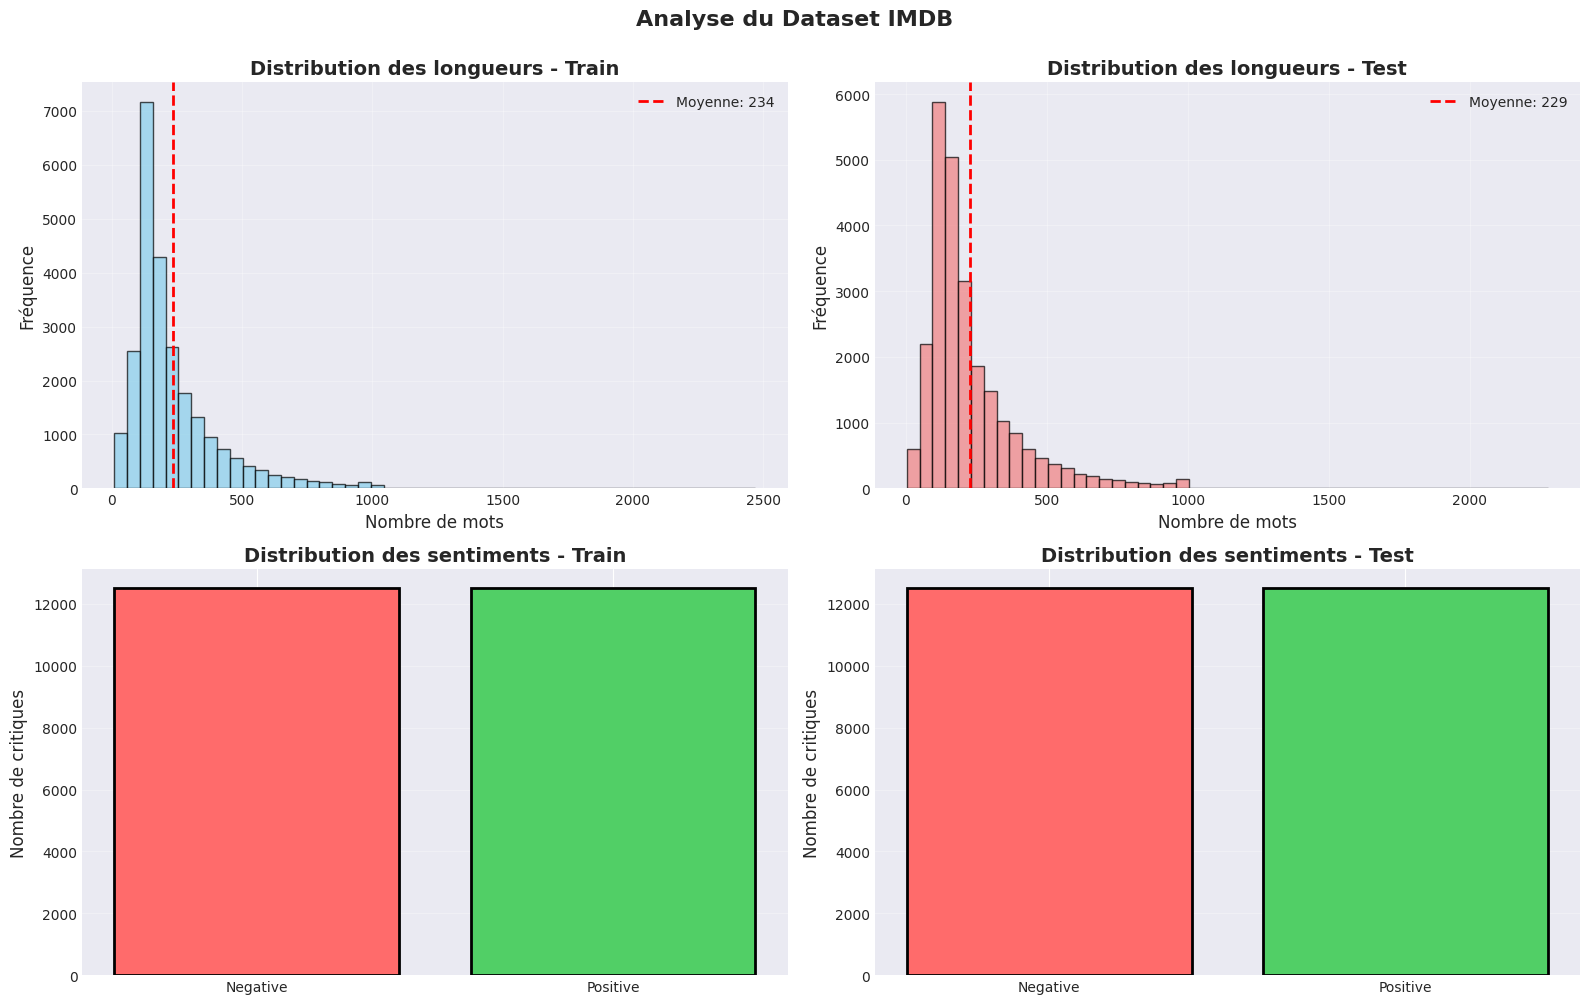


📊 Statistiques détaillées :

Métrique                       Train                Test                
----------------------------------------------------------------------
Nombre de critiques            25000                25000               
Longueur moyenne (mots)        233.8                228.5               
Longueur médiane (mots)        174.0                172.0               
Min / Max (mots)               10 / 2470          4 / 2278         
% Positives                    50.0                 50.0                


In [10]:
# Analyser les longueurs de critiques
train_lengths = [len(review['text'].split()) for review in dataset['train']]
test_lengths = [len(review['text'].split()) for review in dataset['test']]

# Distribution des sentiments
train_labels = [review['label'] for review in dataset['train']]
test_labels = [review['label'] for review in dataset['test']]

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribution des longueurs (train)
axes[0, 0].hist(train_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(train_lengths), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(train_lengths):.0f}')
axes[0, 0].set_xlabel('Nombre de mots', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].set_title('Distribution des longueurs - Train', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Distribution des longueurs (test)
axes[0, 1].hist(test_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(test_lengths), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(test_lengths):.0f}')
axes[0, 1].set_xlabel('Nombre de mots', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Distribution des longueurs - Test', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Distribution des sentiments (train)
sentiment_counts_train = pd.Series(train_labels).value_counts().sort_index()
axes[1, 0].bar(['Negative', 'Positive'], sentiment_counts_train.values, 
               color=['#ff6b6b', '#51cf66'], edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Nombre de critiques', fontsize=12)
axes[1, 0].set_title('Distribution des sentiments - Train', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# Distribution des sentiments (test)
sentiment_counts_test = pd.Series(test_labels).value_counts().sort_index()
axes[1, 1].bar(['Negative', 'Positive'], sentiment_counts_test.values, 
               color=['#ff6b6b', '#51cf66'], edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Nombre de critiques', fontsize=12)
axes[1, 1].set_title('Distribution des sentiments - Test', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.suptitle('Analyse du Dataset IMDB', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Statistiques
print("\n📊 Statistiques détaillées :\n")
print(f"{'Métrique':<30} {'Train':<20} {'Test':<20}")
print("-"*70)
print(f"{'Nombre de critiques':<30} {len(train_lengths):<20} {len(test_lengths):<20}")
print(f"{'Longueur moyenne (mots)':<30} {np.mean(train_lengths):<20.1f} {np.mean(test_lengths):<20.1f}")
print(f"{'Longueur médiane (mots)':<30} {np.median(train_lengths):<20.1f} {np.median(test_lengths):<20.1f}")
print(f"{'Min / Max (mots)':<30} {min(train_lengths)} / {max(train_lengths):<13} {min(test_lengths)} / {max(test_lengths):<13}")
print(f"{'% Positives':<30} {100*sum(train_labels)/len(train_labels):<20.1f} {100*sum(test_labels)/len(test_labels):<20.1f}")

### 4.3 Préparation des données pour le fine-tuning avec KerasNLP

Avec KerasNLP, la préparation est simplifiée :
1. Format des critiques avec prompt (ex: "Review [positive]: ...")
2. Le preprocessor gère automatiquement la tokenization et le padding
3. Utilisation d'un sous-ensemble pour accélérer (configurable)

In [11]:
# Configuration
MAX_LENGTH = 128          # Longueur maximale des séquences
NUM_TRAIN_SAMPLES = 5000  # Nombre d'échantillons d'entraînement (augmentez si temps disponible)
NUM_VAL_SAMPLES = 500     # Nombre d'échantillons de validation
BATCH_SIZE = 8            # Taille du batch (réduisez si manque de mémoire GPU)

print(f"⚙️  Configuration du fine-tuning :")
print(f"  - Longueur max des séquences : {MAX_LENGTH} tokens")
print(f"  - Échantillons d'entraînement : {NUM_TRAIN_SAMPLES}")
print(f"  - Échantillons de validation : {NUM_VAL_SAMPLES}")
print(f"  - Batch size : {BATCH_SIZE}")

def preparer_donnees_imdb(dataset_split, num_samples, ajouter_prompt=True):
    """
    Prépare les données IMDB pour le fine-tuning.
    """
    textes = []
    
    for i in range(min(num_samples, len(dataset_split))):
        review = dataset_split[i]
        sentiment = "positive" if review['label'] == 1 else "negative"
        
        # Format avec prompt (améliore la génération conditionnelle)
        if ajouter_prompt:
            texte = f"Review [{sentiment}]: {review['text']}"
        else:
            texte = review['text']
        
        textes.append(texte)
    
    return textes

print("\n🔧 Préparation des données...\n")

# Préparer train et validation
train_texts = preparer_donnees_imdb(
    dataset['train'], 
    NUM_TRAIN_SAMPLES
)

val_texts = preparer_donnees_imdb(
    dataset['test'], 
    NUM_VAL_SAMPLES
)

print(f"✅ Données préparées !")
print(f"\n  - Train : {len(train_texts)} critiques")
print(f"  - Val   : {len(val_texts)} critiques")

# Exemple de texte préparé
print("\n🔍 Exemple de critique formatée :")
print("\nTexte:")
exemple = train_texts[0][:300] + "..."
print(textwrap.fill(exemple, width=80))

⚙️  Configuration du fine-tuning :
  - Longueur max des séquences : 128 tokens
  - Échantillons d'entraînement : 5000
  - Échantillons de validation : 500
  - Batch size : 8

🔧 Préparation des données...

✅ Données préparées !

  - Train : 5000 critiques
  - Val   : 500 critiques

🔍 Exemple de critique formatée :

Texte:
Review [negative]: I rented I AM CURIOUS-YELLOW from my video store because of
all the controversy that surrounded it when it was first released in 1967. I
also heard that at first it was seized by U.S. customs if it ever tried to enter
this country, therefore being a fan of films considered "contro...


In [12]:
# Créer les datasets TensorFlow avec KerasNLP
print("🔧 Création des datasets TensorFlow...\n")

# Convertir en datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices(train_texts)
val_ds = tf.data.Dataset.from_tensor_slices(val_texts)

# Batching et prefetching
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"✅ Datasets créés !")
print(f"  - Train batches : {len(train_ds)}")
print(f"  - Val batches   : {len(val_ds)}")

🔧 Création des datasets TensorFlow...

✅ Datasets créés !
  - Train batches : 625
  - Val batches   : 63


## 5. Baseline : Feature Extraction (Modèle Frozen)

Avant le fine-tuning complet, testons l'approche **Feature Extraction** :
- On **freeze** toutes les couches du backbone GPT-2
- On laisse trainable la couche de sortie (token_embedding)
- On entraîne **rapidement** pour avoir une baseline

Cette approche est :
- ⚡ **Rapide** à entraîner
- 💾 **Économe** en mémoire
- ✅ **Bonne baseline** pour comparer avec le fine-tuning

In [13]:
print("🧊 Création du modèle avec Feature Extraction (frozen)...\n")

# Créer un nouveau modèle GPT-2 pour le frozen
frozen_model = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor
)

# FREEZE le backbone (toutes les couches transformer)
frozen_model.backbone.trainable = False

# Compter les paramètres
trainable_params = sum([tf.size(w).numpy() for w in frozen_model.trainable_weights])
total_params = sum([tf.size(w).numpy() for w in frozen_model.weights])

print(f"✅ Modèle frozen créé !\n")
print(f"📊 Paramètres :")
print(f"  - Total         : {total_params:,}")
print(f"  - Trainable     : {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"  - Frozen        : {total_params - trainable_params:,} ({100*(total_params-trainable_params)/total_params:.2f}%)")

print("\n🔒 Le backbone Transformer est frozen - seuls les embeddings de sortie sont ajustés.")

🧊 Création du modèle avec Feature Extraction (frozen)...

✅ Modèle frozen créé !

📊 Paramètres :
  - Total         : 124,439,808
  - Trainable     : 0 (0.00%)
  - Frozen        : 124,439,808 (-3.54%)

🔒 Le backbone Transformer est frozen - seuls les embeddings de sortie sont ajustés.


In [14]:
# Compiler le modèle frozen
frozen_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

print("🚀 Entraînement du modèle FROZEN (feature extraction)...\n")

# Callback pour la progression
class SimpleProgressCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs, model_name="Frozen"):
        self.total_epochs = total_epochs
        self.model_name = model_name
        self.history_loss = []
        self.history_val_loss = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.history_loss.append(logs.get('loss', 0))
        self.history_val_loss.append(logs.get('val_loss', 0))
        
        if (epoch + 1) % 1 == 0:
            print(f"Epoch {epoch+1}/{self.total_epochs} - "
                  f"Loss: {logs.get('loss', 0):.4f} - "
                  f"Val Loss: {logs.get('val_loss', 0):.4f}")

callback_frozen = SimpleProgressCallback(total_epochs=3, model_name="Frozen")

# Entraîner (peu d'epochs car frozen)
history_frozen = frozen_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[callback_frozen],
    verbose=0
)

print("\n✅ Entraînement FROZEN terminé !")

🚀 Entraînement du modèle FROZEN (feature extraction)...



2025-11-12 11:06:34.416292: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-11-12 11:06:36.535190: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 240 bytes spill stores, 240 bytes spill loads

2025-11-12 11:06:36.725257: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 452 bytes spill stores, 356 bytes spill loads

2025-11-12 11:06:36.725330: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_110', 388 bytes spill stores, 388 bytes spill loads

2025-11-12 11:06:36.741806: I external/local_xla/xla/stream_ex

Epoch 1/3 - Loss: 4.1146 - Val Loss: 3.8074
Epoch 2/3 - Loss: 4.1155 - Val Loss: 3.8074
Epoch 3/3 - Loss: 4.1156 - Val Loss: 3.8074

✅ Entraînement FROZEN terminé !


### 5.1 Test du modèle frozen

In [15]:
print("🎬 Test du modèle FROZEN (feature extraction)\n")
print("="*80)

test_prompts_frozen = [
    "Review [positive]:",
    "Review [negative]:",
    "This movie was"
]

# Obtenir les stop_token_ids depuis le preprocessor du frozen_model
if hasattr(frozen_model.preprocessor, 'tokenizer') and hasattr(frozen_model.preprocessor.tokenizer, 'end_token_id'):
    frozen_stop_tokens = [frozen_model.preprocessor.tokenizer.end_token_id]
else:
    frozen_stop_tokens = None

for prompt in test_prompts_frozen:
    print(f"\n🌱 Prompt: '{prompt}'")
    generated = frozen_model.generate(
        prompt, 
        max_length=80,
        stop_token_ids=frozen_stop_tokens
    )
    print(f"📝 Généré:\n{textwrap.fill(generated, width=75)}")
    print("-"*80)

print("\n💭 Le modèle frozen montre une légère adaptation mais reste limité.")
print("   Le fine-tuning complet devrait donner de bien meilleurs résultats !")

🎬 Test du modèle FROZEN (feature extraction)


🌱 Prompt: 'Review [positive]:'


2025-11-12 11:07:34.038799: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 300 bytes spill stores, 300 bytes spill loads

2025-11-12 11:07:34.060232: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 632 bytes spill stores, 632 bytes spill loads

2025-11-12 11:07:34.207017: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 428 bytes spill stores, 336 bytes spill loads

2025-11-12 11:07:34.269448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_166', 368 bytes spill stores, 368 bytes spill loads

2025-11-12 11:07:34.388764: I extern

📝 Généré:
Review [positive]:  This review was written by a friend of mine. It is a
great read for those looking for an overview of all the various aspects of
my life, and I think that it would be a good addition to any of my other
books.  It was written as an overview of all the various aspects of my
life, and it was well written.  There
--------------------------------------------------------------------------------

🌱 Prompt: 'Review [negative]:'
📝 Généré:
Review [negative]:  "The story is so good. I was so excited to read it. The
characters are so well done. The story is so well written. There are so
many great things about this manga. It is so well written. The characters
are so well done. The story is so well written. I am so happy that it was
made. It's a very good
--------------------------------------------------------------------------------

🌱 Prompt: 'This movie was'
📝 Généré:
This movie was shot in the summer of 2010. It was released on August 5,
2011.  Contents show]  Plot

## 6. Fine-Tuning Complet (Unfrozen)

Maintenant, passons au **vrai fine-tuning** avec Keras 3 et KerasNLP :
- On **unfreeze** toutes les couches de GPT-2
- On utilise un **learning rate très faible** (éviter catastrophic forgetting)
- On entraîne plus longtemps

### 6.1 Stratégie de fine-tuning

#### Approche progressive (recommandée) :
```
Phase 1: Freeze backbone → Entraîner head (fait ✅)
Phase 2: Unfreeze tout → Fine-tune avec lr faible
```

#### Paramètres clés :
- **Learning rate** : 5e-5 (vs 5e-4 pour frozen)
- **Weight decay** : Régularisation intégrée dans AdamW
- **Gradient clipping** : Éviter exploding gradients

In [16]:
print("🔥 Création du modèle pour FINE-TUNING complet...\n")

# Créer un nouveau modèle GPT-2 (fresh start)
finetuned_model = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor
)

# UNFREEZE toutes les couches
finetuned_model.backbone.trainable = True

# Compter les paramètres
trainable_params = sum([tf.size(w).numpy() for w in finetuned_model.trainable_weights])
total_params = sum([tf.size(w).numpy() for w in finetuned_model.weights])

print(f"✅ Modèle unfrozen créé !\n")
print(f"📊 Paramètres :")
print(f"  - Total         : {total_params:,}")
print(f"  - Trainable     : {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")

print("\n🔓 Tous les paramètres sont trainable - fine-tuning complet activé !")

🔥 Création du modèle pour FINE-TUNING complet...

✅ Modèle unfrozen créé !

📊 Paramètres :
  - Total         : 124,439,808
  - Trainable     : 124,439,808 (-3.54%)

🔓 Tous les paramètres sont trainable - fine-tuning complet activé !


In [17]:
# Configuration de l'optimizer avec weight decay (AdamW)
NUM_EPOCHS_FINETUNE = 3
LEARNING_RATE = 5e-5

print(f"⚙️  Configuration du fine-tuning :")
print(f"  - Learning rate      : {LEARNING_RATE}")
print(f"  - Epochs             : {NUM_EPOCHS_FINETUNE}")
print(f"  - Optimizer          : AdamW (avec weight decay)")

# Compiler avec AdamW (Adam avec weight decay)
finetuned_model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

print("\n✅ Optimizer configuré avec weight decay !")

⚙️  Configuration du fine-tuning :
  - Learning rate      : 5e-05
  - Epochs             : 3
  - Optimizer          : AdamW (avec weight decay)

✅ Optimizer configuré avec weight decay !


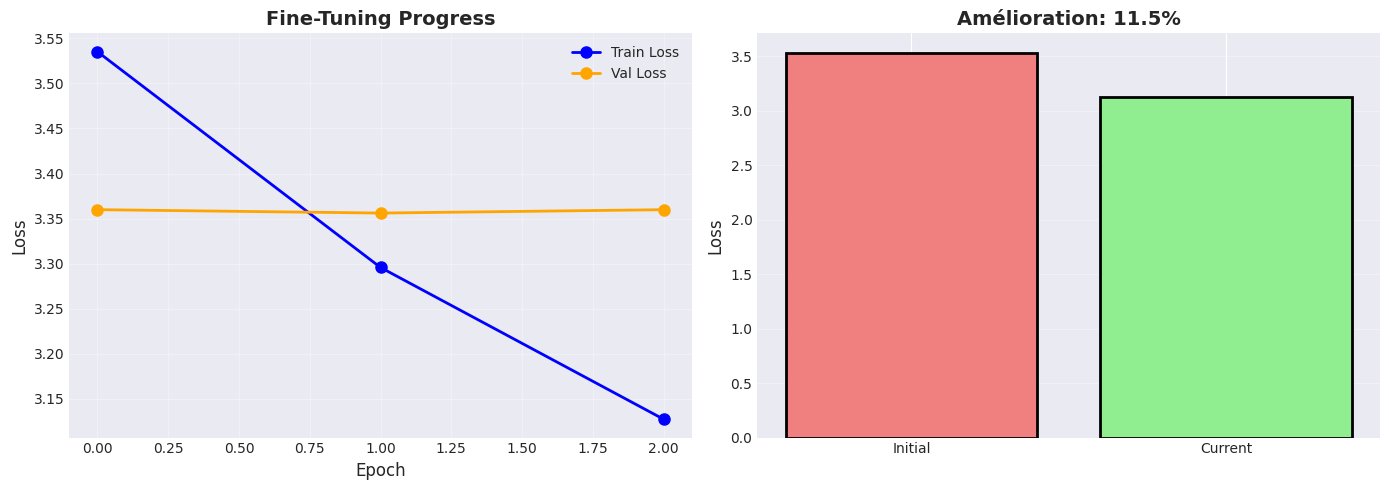

Epoch 3/3
Train Loss: 3.1274 | Val Loss: 3.3599

✅ Fine-tuning terminé !

🎉 Le modèle est maintenant spécialisé dans les critiques de films IMDB !


In [18]:
print("🚀 Début du FINE-TUNING complet...\n")
print("⏳ Cela peut prendre du temps (plusieurs minutes selon GPU)...\n")

# Callback avec visualisation
class FineTuningCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs
        self.history_loss = []
        self.history_val_loss = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.history_loss.append(logs.get('loss', 0))
        self.history_val_loss.append(logs.get('val_loss', 0))
        
        clear_output(wait=True)
        
        # Graphique
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history_loss, 'o-', color='blue', linewidth=2, markersize=8, label='Train Loss')
        plt.plot(self.history_val_loss, 'o-', color='orange', linewidth=2, markersize=8, label='Val Loss')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Fine-Tuning Progress', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)
        
        plt.subplot(1, 2, 2)
        if len(self.history_loss) > 1:
            improvement = ((self.history_loss[0] - self.history_loss[-1]) / self.history_loss[0]) * 100
            plt.bar(['Initial', 'Current'], [self.history_loss[0], self.history_loss[-1]], 
                    color=['lightcoral', 'lightgreen'], edgecolor='black', linewidth=2)
            plt.ylabel('Loss', fontsize=12)
            plt.title(f'Amélioration: {improvement:.1f}%', fontsize=14, fontweight='bold')
            plt.grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Epoch {epoch+1}/{self.total_epochs}")
        print(f"Train Loss: {logs.get('loss', 0):.4f} | Val Loss: {logs.get('val_loss', 0):.4f}")

callback_finetune = FineTuningCallback(total_epochs=NUM_EPOCHS_FINETUNE)

# Entraîner
history_finetuned = finetuned_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS_FINETUNE,
    callbacks=[callback_finetune],
    verbose=0
)

print("\n✅ Fine-tuning terminé !")
print("\n🎉 Le modèle est maintenant spécialisé dans les critiques de films IMDB !")

## 7. Comparaison des Trois Modèles

Nous avons maintenant trois modèles à comparer :
1. **GPT-2 pré-entraîné** (baseline, aucun entraînement sur IMDB)
2. **Feature extraction** (frozen, embeddings de sortie ajustés)
3. **Fine-tuned** (unfrozen, tous les poids ajustés)

### 7.1 Comparaison des métriques

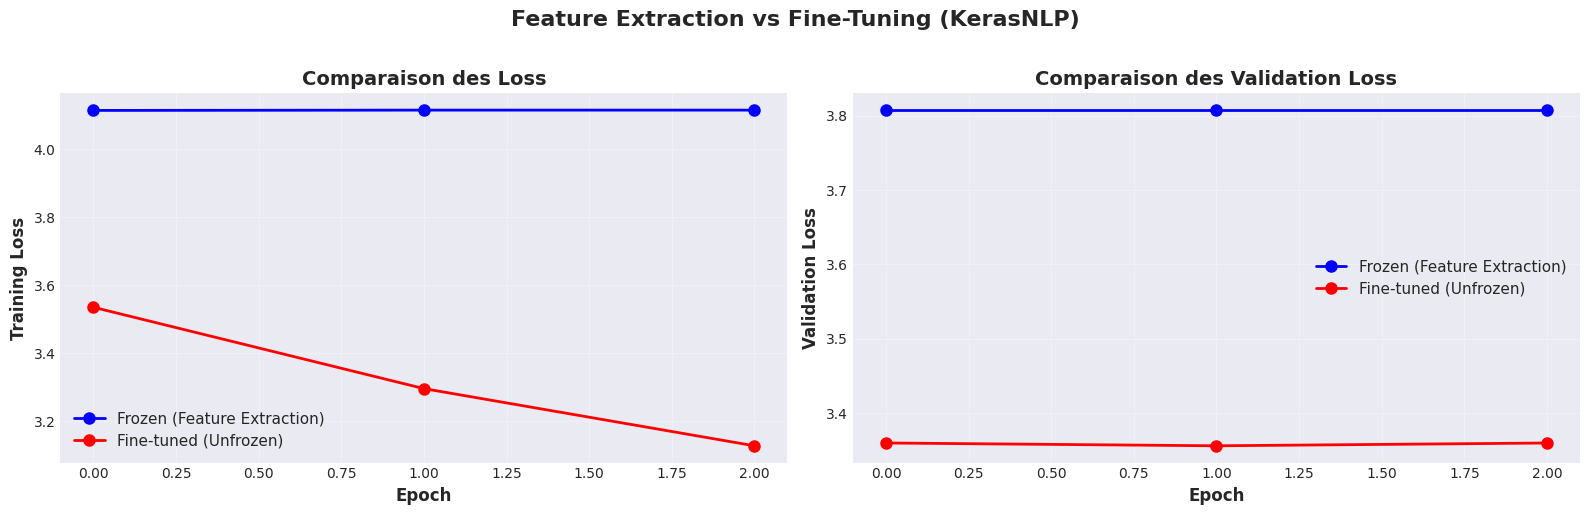


📊 Résumé des performances

Modèle                         Train Loss Finale    Val Loss Finale     
--------------------------------------------------------------------------------
Frozen (Feature Extraction)    4.1156               3.8074              
Fine-tuned (Unfrozen)          3.1274               3.3599              
--------------------------------------------------------------------------------

🏆 Le fine-tuning améliore la validation loss de 11.8% !


In [19]:
# Comparer les courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(callback_frozen.history_loss, 'o-', color='blue', linewidth=2, 
             markersize=8, label='Frozen (Feature Extraction)')
axes[0].plot(callback_finetune.history_loss, 'o-', color='red', linewidth=2, 
             markersize=8, label='Fine-tuned (Unfrozen)')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Training Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Comparaison des Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Validation Loss
axes[1].plot(callback_frozen.history_val_loss, 'o-', color='blue', linewidth=2, 
             markersize=8, label='Frozen (Feature Extraction)')
axes[1].plot(callback_finetune.history_val_loss, 'o-', color='red', linewidth=2, 
             markersize=8, label='Fine-tuned (Unfrozen)')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Comparaison des Validation Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.suptitle('Feature Extraction vs Fine-Tuning (KerasNLP)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tableau comparatif
print("\n📊 Résumé des performances\n")
print("="*80)
print(f"{'Modèle':<30} {'Train Loss Finale':<20} {'Val Loss Finale':<20}")
print("-"*80)
print(f"{'Frozen (Feature Extraction)':<30} {callback_frozen.history_loss[-1]:<20.4f} {callback_frozen.history_val_loss[-1]:<20.4f}")
print(f"{'Fine-tuned (Unfrozen)':<30} {callback_finetune.history_loss[-1]:<20.4f} {callback_finetune.history_val_loss[-1]:<20.4f}")
print("-"*80)

# Amélioration
improvement = ((callback_frozen.history_val_loss[-1] - callback_finetune.history_val_loss[-1]) / 
               callback_frozen.history_val_loss[-1]) * 100

if improvement > 0:
    print(f"\n🏆 Le fine-tuning améliore la validation loss de {improvement:.1f}% !")
else:
    print(f"\n⚠️  Le frozen model performe mieux (peut nécessiter plus d'epochs pour le fine-tuning)")

### 7.2 Comparaison qualitative : Génération de critiques

Le vrai test : **la qualité des critiques générées** !

In [20]:
print("🎬 COMPARAISON QUALITATIVE : Génération de critiques de films\n")
print("="*80)
print("\nNous allons comparer les trois modèles sur les mêmes prompts :\n")

test_prompts_comparison = [
    "Review [positive]: This movie was absolutely",
    "Review [negative]: The film was a complete",
    "Review [positive]: I loved the acting because",
]

models_to_compare = [
    ("GPT-2 Pré-entraîné (AVANT fine-tuning)", gpt2_model, "🔵"),
    ("Feature Extraction (Frozen)", frozen_model, "🟢"),
    ("Fine-tuned (Unfrozen)", finetuned_model, "🔴")
]

for prompt in test_prompts_comparison:
    print(f"\n{'='*80}")
    print(f"🌱 Prompt: '{prompt}'")
    print(f"{'='*80}\n")
    
    for model_name, model, emoji in models_to_compare:
        # Obtenir les stop_token_ids pour chaque modèle
        if hasattr(model, 'preprocessor') and model.preprocessor is not None:
            if hasattr(model.preprocessor, 'tokenizer') and hasattr(model.preprocessor.tokenizer, 'end_token_id'):
                stop_tokens = [model.preprocessor.tokenizer.end_token_id]
            else:
                stop_tokens = None
        else:
            stop_tokens = None
        
        generated = model.generate(
            prompt, 
            max_length=100,
            stop_token_ids=stop_tokens
        )
        
        print(f"{emoji} {model_name}:")
        print(textwrap.fill(generated, width=75, initial_indent='   ', subsequent_indent='   '))
        print()

print("\n" + "="*80)
print("\n💡 Observations :")
print("  - Le modèle pré-entraîné génère du texte générique")
print("  - Le modèle frozen s'améliore légèrement")
print("  - Le modèle fine-tuned génère des critiques plus authentiques et cohérentes !")

🎬 COMPARAISON QUALITATIVE : Génération de critiques de films


Nous allons comparer les trois modèles sur les mêmes prompts :


🌱 Prompt: 'Review [positive]: This movie was absolutely'



2025-11-12 11:10:42.671463: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 300 bytes spill stores, 300 bytes spill loads

2025-11-12 11:10:42.780812: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 640 bytes spill stores, 640 bytes spill loads

2025-11-12 11:10:42.887545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 428 bytes spill stores, 336 bytes spill loads

2025-11-12 11:10:42.923729: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 908 bytes spill stores, 908 bytes spill loads

2025-11-12 11:10:43.036530: I extern

🔵 GPT-2 Pré-entraîné (AVANT fine-tuning):
   Review [positive]: This movie was absolutely amazing, and I can't wait
   to see it come out on DVD.  Rating [negative]: I have been watching this
   movie for the last couple weeks and am very impressed with how it turned
   out. It is a very well done and well written story with a strong story,
   a great cast, and a great story. I highly recommend it.  Overall  I love
   this movie. It is one of those movies that makes you want

🟢 Feature Extraction (Frozen):
   Review [positive]: This movie was absolutely awesome. The story was
   really good and the acting was fantastic. The acting wasn't bad, but the
   story was a bit too long, so I had to go back and watch the film a few
   times. I think I was just too busy with my work to enjoy this film so
   much.  Score [positive]: The movie is a great movie. The music was
   fantastic. The acting was great. The acting wasn't bad, but the story

🔴 Fine-tuned (Unfrozen):
   Review [positive]: Thi

## 8. Génération Interactive : À Vous de Jouer !

Testez le modèle fine-tuned avec vos propres prompts !

In [21]:
def generer_critique_interactive(model, sentiment="positive", debut="", num_samples=3):
    """
    Génère plusieurs critiques avec un prompt personnalisé.
    """
    if debut:
        prompt = f"Review [{sentiment}]: {debut}"
    else:
        prompt = f"Review [{sentiment}]:"
    
    print(f"\n🎬 Génération de {num_samples} critiques {sentiment.upper()}")
    print(f"🌱 Prompt de départ: '{prompt}'\n")
    print("="*80)
    
    # Obtenir les stop_token_ids depuis le preprocessor du modèle
    if hasattr(model, 'preprocessor') and model.preprocessor is not None:
        if hasattr(model.preprocessor, 'tokenizer') and hasattr(model.preprocessor.tokenizer, 'end_token_id'):
            stop_tokens = [model.preprocessor.tokenizer.end_token_id]
        else:
            stop_tokens = None
    else:
        stop_tokens = None
    
    for i in range(num_samples):
        generated = model.generate(
            prompt, 
            max_length=120,
            stop_token_ids=stop_tokens
        )
        
        print(f"\n📝 Critique #{i+1}:")
        print(textwrap.fill(generated, width=75, initial_indent='   ', subsequent_indent='   '))
        print("-"*80)

# Exemples d'utilisation
print("\n🎭 GÉNÉRATION INTERACTIVE AVEC KERASNLP\n")

# Critiques positives
generer_critique_interactive(
    finetuned_model, 
    sentiment="positive",
    debut="This masterpiece",
    num_samples=2
)

# Critiques négatives
generer_critique_interactive(
    finetuned_model, 
    sentiment="negative",
    debut="Unfortunately, this movie",
    num_samples=2
)


🎭 GÉNÉRATION INTERACTIVE AVEC KERASNLP


🎬 Génération de 2 critiques POSITIVE
🌱 Prompt de départ: 'Review [positive]: This masterpiece'



2025-11-12 11:11:03.976690: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 300 bytes spill stores, 300 bytes spill loads

2025-11-12 11:11:04.127545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 640 bytes spill stores, 640 bytes spill loads

2025-11-12 11:11:04.182648: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 428 bytes spill stores, 336 bytes spill loads

2025-11-12 11:11:04.231344: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 908 bytes spill stores, 908 bytes spill loads

2025-11-12 11:11:04.232963: I extern


📝 Critique #1:
   Review [positive]: This masterpiece is the epitome of a movie. I am not
   sure why, but the story and the acting are not even close to what I
   expected from such a movie. The plot was not that great, but it did make
   for an enjoyable viewing experience. The movie is set in the future, and
   it does have the appearance of an early 1900's cartoon. The story is set
   in the early 20th century, and it does not follow a very modern story.
   The story is very predictable, with a few twists and turns that would
   have made it more interesting. The
--------------------------------------------------------------------------------

📝 Critique #2:
   Review [positive]: This masterpiece of a horror movie was just a bit
   overrated, and I'm glad to be the only one who actually liked this
   movie. The first half was really scary, and that's saying something for
   this one. First off, the first half was just a bunch of people being
   scared, and then, the second and thi

### 8.1 Personnalisez vos propres critiques

Modifiez les paramètres ci-dessous pour créer vos propres critiques !

In [22]:
# 🎨 PERSONNALISEZ ICI
MON_SENTIMENT = "positive"  # ou "negative"
MON_DEBUT = "The cinematography was"  # Votre début de phrase
NOMBRE_CRITIQUES = 3

# Générer
prompt_perso = f"Review [{MON_SENTIMENT}]: {MON_DEBUT}"

print(f"\n🎨 VOS CRITIQUES PERSONNALISÉES\n")
print(f"Sentiment: {MON_SENTIMENT.upper()}\n")
print("="*80)

# Obtenir les stop_token_ids pour le finetuned_model
if hasattr(finetuned_model, 'preprocessor') and finetuned_model.preprocessor is not None:
    if hasattr(finetuned_model.preprocessor, 'tokenizer') and hasattr(finetuned_model.preprocessor.tokenizer, 'end_token_id'):
        finetuned_stop_tokens = [finetuned_model.preprocessor.tokenizer.end_token_id]
    else:
        finetuned_stop_tokens = None
else:
    finetuned_stop_tokens = None

for i in range(NOMBRE_CRITIQUES):
    generated = finetuned_model.generate(
        prompt_perso,
        max_length=100,
        stop_token_ids=finetuned_stop_tokens
    )
    
    print(f"\n🎬 Critique #{i+1}:")
    print(textwrap.fill(generated, width=75, initial_indent='   ', subsequent_indent='   '))
    print("-"*80)


🎨 VOS CRITIQUES PERSONNALISÉES

Sentiment: POSITIVE


🎬 Critique #1:
   Review [positive]: The cinematography was terrible. The acting was
   terrible. The plot was awful. The plot was just so stupid that it made
   it hard for me to watch the entire film. I was so disappointed that I
   didn't get any more enjoyment from it. I was hoping that this movie
   could be the end of the movie, or at least the start. The ending was
   really lame. I thought that it was supposed to be a "good-bad" ending,
   like "The
--------------------------------------------------------------------------------

🎬 Critique #2:
   Review [positive]: The cinematography was good, the actors were good,
   and the special effects were good. However, the movie was poorly
   directed and the special effects were not as good or convincing as they
   might seem. The story was very confusing, and the acting was poor, but
   it was not very good. I found myself wondering what happened to the
   characters, who were n

## 9. Analyse et Conclusions

### 9.1 Résumé des apprentissages

Dans ce notebook, nous avons exploré le **Transfer Learning** et le **Fine-Tuning** en NLP avec **Keras 3** et **KerasNLP** :

#### 🎯 Ce que nous avons appris :

1. **Keras 3 et KerasNLP** :
   - API moderne et simplifiée pour le NLP
   - Modèles pré-entraînés prêts à l'emploi
   - Tokenizers et preprocessors intégrés
   - Fine-tuning natif avec Keras

2. **Transfer Learning** :
   - Réutiliser des modèles pré-entraînés sur des tâches massives
   - Économiser du temps et des ressources computationnelles
   - Obtenir de meilleures performances avec moins de données

3. **Deux approches** :
   - **Feature Extraction (Frozen)** : Rapide, économique, bonne baseline
   - **Fine-Tuning (Unfrozen)** : Plus lent, mais meilleures performances

4. **GPT-2 avec KerasNLP** :
   - Chargement simplifié avec `from_preset()`
   - Génération facile avec `generate()`
   - Fine-tuning transparent

5. **Dataset IMDB** :
   - 50,000 critiques de films authentiques
   - Fine-tuning pour adapter GPT-2 au domaine du cinéma
   - Génération conditionnelle (positive/négative)

### 9.2 Comparaison finale

In [23]:
# Tableau comparatif final
print("\n📊 COMPARAISON FINALE DES APPROCHES (Keras 3 + KerasNLP)\n")
print("="*90)

comparison_data = {
    'Approche': [
        'GPT-2 Pré-entraîné',
        'Feature Extraction (Frozen)',
        'Fine-Tuning (Unfrozen)'
    ],
    'Temps Entraînement': [
        'N/A',
        '⭐ Rapide (3 epochs)',
        '⭐⭐⭐ Plus lent (3 epochs)'
    ],
    'Qualité Génération': [
        '⭐⭐ Générique',
        '⭐⭐⭐ Correct',
        '⭐⭐⭐⭐⭐ Excellent'
    ],
    'Adaptation IMDB': [
        '❌ Aucune',
        '✅ Légère',
        '✅✅✅ Forte'
    ],
    'Facilité KerasNLP': [
        '⭐⭐⭐⭐⭐ Très facile',
        '⭐⭐⭐⭐⭐ Très facile',
        '⭐⭐⭐⭐⭐ Très facile'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))
print("="*90)

print("\n💡 AVANTAGES DE KERAS 3 + KERASNLP :")
print("\n1. 🚀 API Simplifiée :")
print("   - Chargement en une ligne : GPT2CausalLM.from_preset()")
print("   - Génération native : model.generate()")
print("   - Pas besoin de gérer manuellement les tokens spéciaux")

print("\n2. 🎯 Intégration Complète :")
print("   - Tokenizer et preprocessor compatibles")
print("   - Fine-tuning natif avec Keras API")
print("   - Callbacks et métriques Keras standards")

print("\n3. ⚡ Performance :")
print("   - Backend TensorFlow optimisé")
print("   - Compilation XLA automatique (si disponible)")
print("   - Multi-backend support (TensorFlow, JAX, PyTorch)")

print("\n4. 📚 Écosystème :")
print("   - Nombreux modèles pré-entraînés disponibles")
print("   - Documentation complète et exemples")
print("   - Communauté active")


📊 COMPARAISON FINALE DES APPROCHES (Keras 3 + KerasNLP)

                   Approche       Temps Entraînement Qualité Génération Adaptation IMDB Facilité KerasNLP
         GPT-2 Pré-entraîné                      N/A       ⭐⭐ Générique        ❌ Aucune ⭐⭐⭐⭐⭐ Très facile
Feature Extraction (Frozen)      ⭐ Rapide (3 epochs)        ⭐⭐⭐ Correct        ✅ Légère ⭐⭐⭐⭐⭐ Très facile
     Fine-Tuning (Unfrozen) ⭐⭐⭐ Plus lent (3 epochs)    ⭐⭐⭐⭐⭐ Excellent       ✅✅✅ Forte ⭐⭐⭐⭐⭐ Très facile

💡 AVANTAGES DE KERAS 3 + KERASNLP :

1. 🚀 API Simplifiée :
   - Chargement en une ligne : GPT2CausalLM.from_preset()
   - Génération native : model.generate()
   - Pas besoin de gérer manuellement les tokens spéciaux

2. 🎯 Intégration Complète :
   - Tokenizer et preprocessor compatibles
   - Fine-tuning natif avec Keras API
   - Callbacks et métriques Keras standards

3. ⚡ Performance :
   - Backend TensorFlow optimisé
   - Compilation XLA automatique (si disponible)
   - Multi-backend support (TensorFlow, JAX,

### 9.3 Pour aller plus loin

#### 🚀 Améliorations possibles :

1. **Plus de données** :
   - Augmenter NUM_TRAIN_SAMPLES à 10,000 ou 25,000
   - Utiliser l'ensemble complet du dataset IMDB

2. **Modèles plus grands** :
   - GPT-2 Medium : `gpt2_medium_en`
   - GPT-2 Large : `gpt2_large_en`
   - Autres modèles KerasNLP : BERT, T5, etc.

3. **Hyperparamètres** :
   - Tester différents learning rates
   - Ajuster le weight decay
   - Expérimenter avec les epochs

4. **Techniques avancées avec KerasNLP** :
   - **Mixed precision** : Accélérer l'entraînement
   - **Gradient accumulation** : Simuler de plus grands batches
   - **Custom sampling strategies** : Top-k, top-p, temperature

5. **Évaluation quantitative** :
   - Perplexité sur le test set
   - BLEU score pour la qualité de génération
   - Classifieur de sentiment pour vérifier la cohérence

#### 📚 Ressources additionnelles :

- [KerasNLP Documentation](https://keras.io/keras_nlp/)
- [Keras 3 Guide](https://keras.io/keras_3/)
- [GPT-2 Paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
- [Transfer Learning in NLP](https://ruder.io/transfer-learning/)

### 9.4 Exercices suggérés

1. **Augmenter les données** : Utiliser 10,000 échantillons au lieu de 5,000
2. **Tester d'autres presets** : Essayer `gpt2_medium_en` ou `gpt2_large_en`
3. **Comparer avec d'autres modèles** : BERT, T5 disponibles dans KerasNLP
4. **Ajouter du prompt engineering** : Tester différents formats de prompts
5. **Fine-tuner sur un autre dataset** : Essayer avec des tweets, des articles, etc.

---

## 🎉 Félicitations !

Vous maîtrisez maintenant le **Fine-Tuning** et le **Transfer Learning** en NLP avec **Keras 3** et **KerasNLP** !

**Ce que vous savez faire** :
- ✅ Utiliser KerasNLP pour charger des modèles pré-entraînés
- ✅ Comprendre les différences entre frozen et unfrozen
- ✅ Fine-tuner GPT-2 sur une tâche spécifique
- ✅ Générer du texte de qualité avec KerasNLP
- ✅ Comparer différentes approches de transfer learning
- ✅ Utiliser l'API moderne de Keras 3

**Prochaines étapes** :
- 🚀 Essayer d'autres modèles KerasNLP (BERT, T5, OPT)
- 🎯 Appliquer à vos propres projets
- 📊 Explorer d'autres tâches NLP (classification, NER, Q&A)
- 🔬 Contribuer à la communauté KerasNLP

---

*Notebook créé avec ❤️ pour l'apprentissage du Transfer Learning en NLP avec Keras 3 et KerasNLP*